In [72]:
%matplotlib inline

import pandas as pd
import numpy as np
import seaborn as sns
import itertools
import matplotlib.pyplot as plt
from scipy import stats

In [73]:
def confusao(truth, pred):
    retorno = {'tp':0,'fp':0, 'tn':0, 'fn':0}
    for x in range(len(pred)):
        if pred[x] == 1 and truth[x] == 1:
            acumulo = 'tp'
        elif pred[x] == 0 and truth[x] == 1:
            acumulo = 'fn'
        elif pred[x] == 1 and truth[x] == 0:
            acumulo = 'fp'
        else:
            acumulo = 'tn'
        
        retorno[acumulo] += 1
    
    retorno['precisao_relativa'] = retorno['tp'] / sum(truth)
    
    return retorno

In [74]:
objetos = ['medicine','chocolate_milk', 'heineken', 'yellow_juice',
           'red_juice', 'purple_juice', 'milk_bottle', 'milk_box',
           'cereal', 'iron_man', 'shampoo', 'monster', 'tea_box']
gabarito = pd.read_csv('gabarito_objetos.csv', index_col='imagem')
resultados = pd.read_csv('logfile.csv')

In [75]:
matriz_confusao = pd.DataFrame(columns=['tp','fp','tn','fn','precisao_relativa'])

for index, row in resultados.iterrows():
    imagem = row['image']
    verdade = list(gabarito.loc[imagem, :])
    predicao = list(row[objetos])
    vetor_confusao = confusao(verdade, predicao)
    
    for valor in vetor_confusao:
        matriz_confusao.loc[index, valor] = vetor_confusao[valor]

resultados = pd.concat([resultados, matriz_confusao], axis=1)
resultados[objetos + ['tp','fp','tn','fn']] = resultados[objetos + ['tp','fp','tn','fn']].astype('int')
resultados['precisao_relativa'] = resultados['precisao_relativa'].astype('float')
# resultados[['tp','fp','tn','fn']] /= len(objetos)

In [78]:
resultados_classes = resultados[resultados['detector'] != 'ssd']
resultados_classes[['pontos','base']] = resultados_classes[['pontos','base']].astype('int')
resultados_classes['meu_filtro'] = resultados_classes['detector'] + resultados_classes['sensor']
resultados_classes['meu_filtro'].unique()

/usr/local/lib/python3.5/dist-packages/pandas/core/frame.py:2540: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


array(['SIFTcamera_hd', 'RootSIFTcamera_hd', 'SIFTkinect_velho',
       'RootSIFTkinect_velho'], dtype=object)

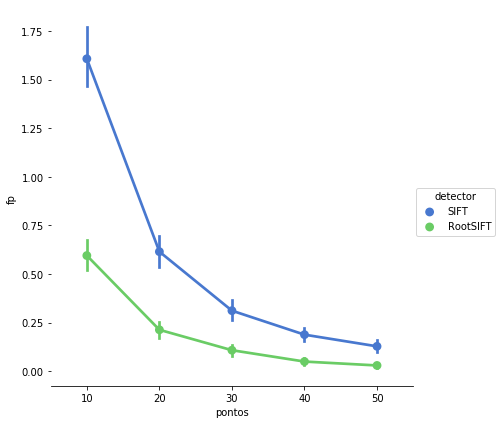

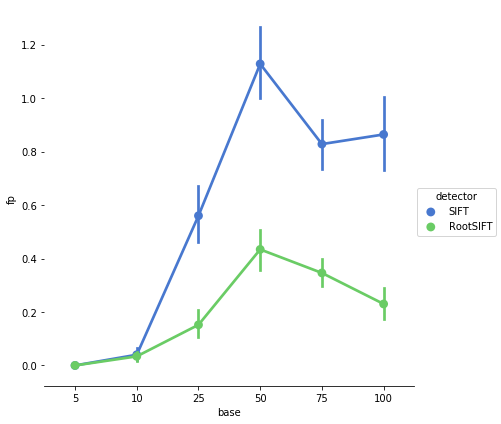

In [96]:
for valor_de_interesse in ['pontos', 'base']:
    g = sns.factorplot(x=valor_de_interesse, y='fp', hue='detector', data=resultados_classes,
                       size=6, palette='muted')
    g.despine(left=True)
#     plt.savefig('precisao_relativa_x_'+valor_de_interesse + '.pdf')

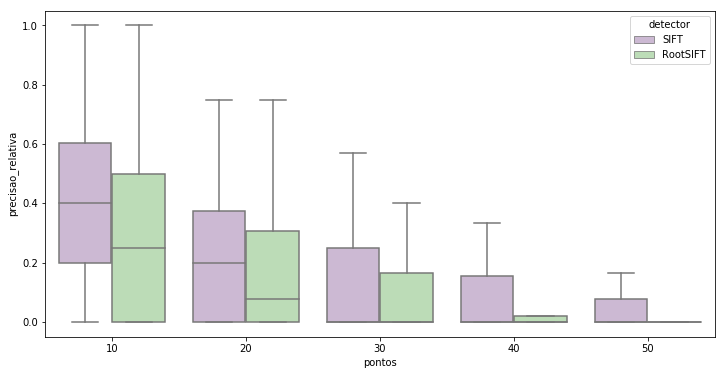

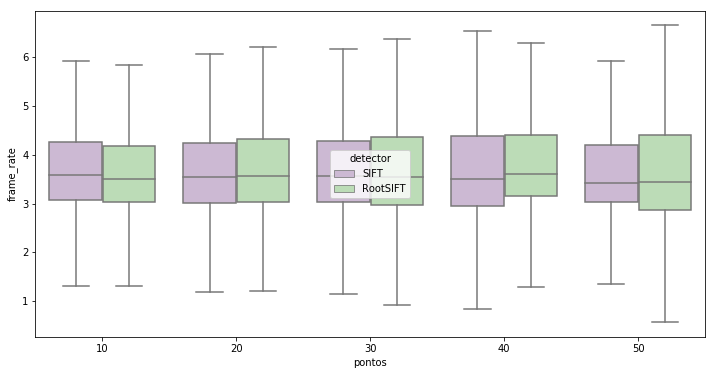

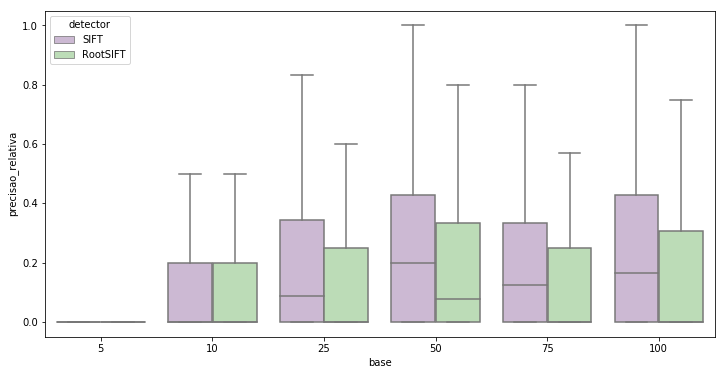

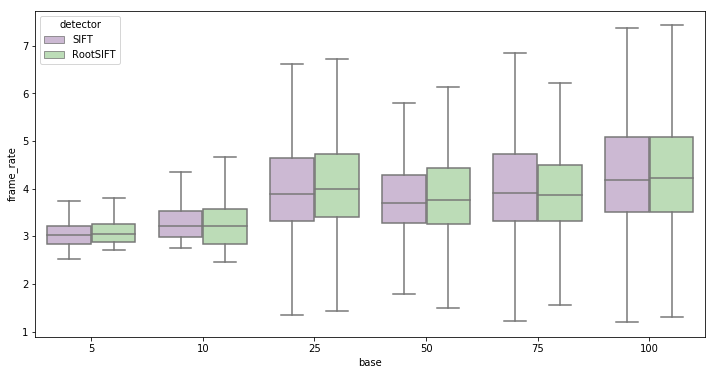

In [86]:
for valor_de_interesse in ['pontos', 'base']:
    fig, ax = plt.subplots(figsize=(12,6))
    sns.boxplot(x=valor_de_interesse, y="precisao_relativa", hue="detector", data=resultados_classes, palette="PRGn", showfliers=False)
    plt.show()
    fig, ax = plt.subplots(figsize=(12,6))    
    sns.boxplot(x=valor_de_interesse, y='frame_rate', hue='detector', data=resultados_classes, palette='PRGn', showfliers=False)
    plt.show()
#     plt.savefig('precisao_relativa_x_'+valor_de_interesse + '.pdf')


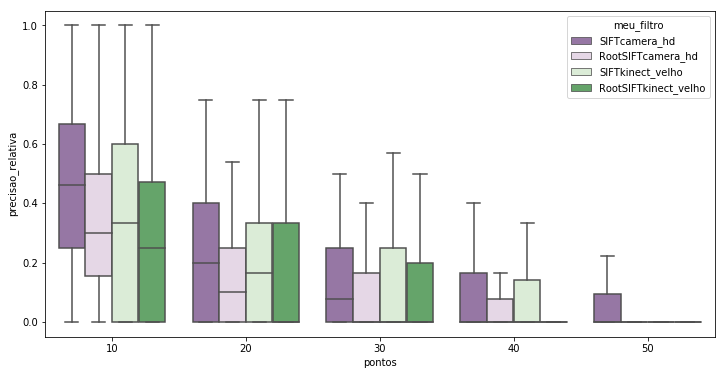

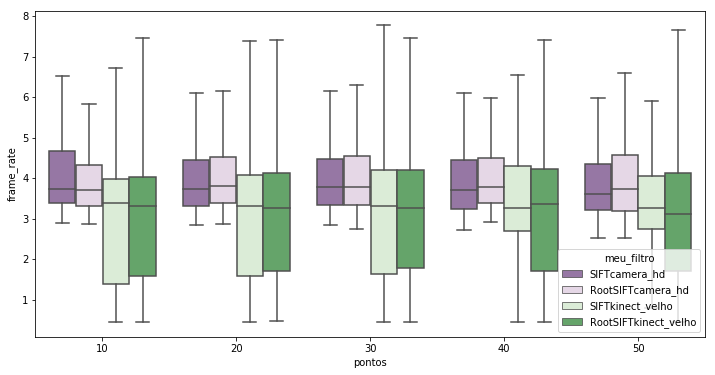

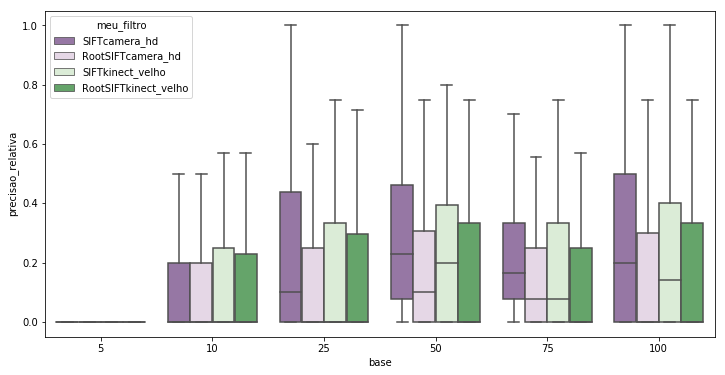

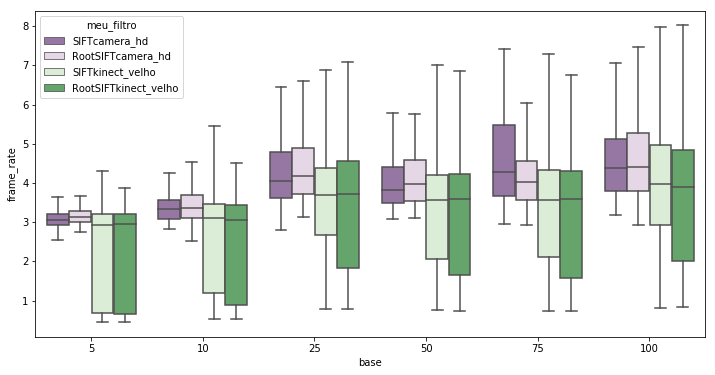

In [97]:
for valor_de_interesse in ['pontos', 'base']:
    fig, ax = plt.subplots(figsize=(12,6))
    sns.boxplot(ax=ax, x=valor_de_interesse, y="precisao_relativa", hue="meu_filtro", data=resultados_classes, palette="PRGn", showfliers=False)
    plt.show()
    fig, ax = plt.subplots(figsize=(12,6))
    sns.boxplot(ax=ax, x=valor_de_interesse, y='frame_rate', hue="meu_filtro", data=resultados_classes, palette='PRGn', showfliers=False)
    plt.show()

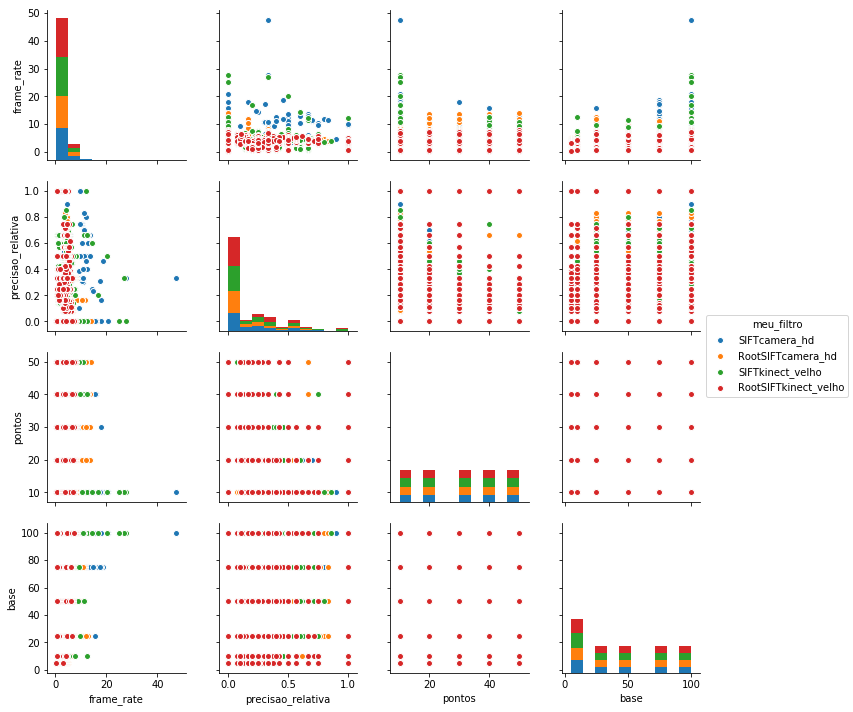

In [90]:
resultados_classes_filtrado = resultados_classes[['frame_rate', 'precisao_relativa', 'pontos', 'base', 'meu_filtro']]
sns.pairplot(resultados_classes_filtrado, hue='meu_filtro')

In [82]:
x = [a for a in range(10,51,10)]
y = [5,10,25,50,75,100]
z = ['RootSIFT', 'SIFT']

results_list = []
for detector in list(itertools.combinations_with_replacement(z,2)):
    for value in list(itertools.combinations_with_replacement(x,2)):
        for item in list(itertools.combinations_with_replacement(y,2)):
            a = resultados[(resultados['detector']==detector[0]) & (resultados['pontos']==value[0]) & (resultados['base']==item[0])]['precisao_relativa']
            b = resultados[(resultados['detector']==detector[1]) & (resultados['pontos']==value[1]) & (resultados['base']==item[1])]['precisao_relativa']
            string_a = detector[0]+'_'+str(value[0])+'_'+str(item[0])
            string_b = detector[1]+'_'+str(value[1])+'_'+str(item[1])
            equal=True if item[0]==item[1] and value[0]==value[1] and detector[0]==detector[1] else results_list.append((string_a,string_b,stats.ttest_rel(a,b)))# print(stats.ttest_rel(a,b),detector,value,item)

for detector in z:
    for value in x:
        for item in y:
            a = resultados[(resultados['detector']==detector) & (resultados['pontos']==value) & (resultados['base']==item)]['precisao_relativa']
            c = resultados[(resultados['detector']=='ssd')]['precisao_relativa']
            string_a = detector+'_'+str(value)+'_'+str(item)
            results_list.append((string_a,'ssd',stats.ttest_rel(a,c)))

# [print(results_list[x]) for x in range(len(results_list))]

In [85]:
csv_list = [('method_points_%folder', 'method_points_%folder 2', 'statistic', 'pvalue')]

for item in results_list:
#     if item[2].pvalue < 0.001:
#         pvalue = 0
#     else:
#         pvalue = item[2].pvalue
    csv_list.append((item[0], item[1], item[2].statistic, item[2].pvalue))

df = pd.DataFrame(csv_list)
df.to_csv('T_test.csv', encoding='utf-8', index=False)